# First plot in paper

27th May 2024

Map of HMA with the regional delimitations and major rivers.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import geopandas as gpd
from tqdm import tqdm
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
from cartopy.io import shapereader
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import cartopy.feature as cf
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.patheffects as pe

import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')  # noqa
from load import data_dir

from shapely.geometry import LinearRing


/Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_59375/2540671114.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely

## Load data

In [3]:
# Topography data
top_ds = xr.open_dataset(data_dir + 'Elevation/GMTED2010_15n015_00625deg.nc')
top_ds = top_ds.assign_coords(
    {'nlat': top_ds.latitude, 'nlon': top_ds.longitude})
top_ds1 = top_ds.sel(nlat=slice(15, 55), nlon=slice(60, 120))
top_ds1['elevation'] = top_ds1.elevation.interpolate_na(dim='nlat', method='linear')


In [4]:
# Mountain regions 2
mountains_path = '/Users/kenzatazi/Downloads/GlacReg_2023/GTN-G_202307_o2regions.shp'
mountains_shape = shapereader.Reader(mountains_path)
mountains_globe = ccrs.Globe(semimajor_axis=6377276.345, inverse_flattening=300.8017)

In [5]:
# Cartopy river shapefiles
fpath = data_dir +"/Shapefiles/ne_50m_rivers_lake_centerlines_scale_rank/ne_50m_rivers_lake_centerlines_scale_rank.shp"
as_shp = shapereader.Reader(fpath)

In [6]:
rivers_gdf4 = gpd.read_file('dataframe.shp')

In [7]:
# Glaciers shapefiles
glaciers14_path = '/Users/kenzatazi/Downloads/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp'
glaciers15_path = '/Users/kenzatazi/Downloads/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'
glaciers13_path = '/Users/kenzatazi/Downloads/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp'

In [8]:
perm_da = xr.open_dataset('/Users/kenzatazi/Downloads/ESACCI-PERMAFROST-L4-PFR-MODISLST_CRYOGRID-AREA4_PP-2019-fv03.0.nc')

In [9]:
perm_da_sli = perm_da.sel(x=slice(5.16e6,8e6)).isel(time=0) 

In [10]:
perm_da_sli

<xarray.Dataset>
Dimensions:              (x: 2597, y: 10353)
Coordinates:
    time                 datetime64[ns] 2019-01-01
  * x                    (x) float64 5.161e+06 5.162e+06 ... 7.566e+06 7.566e+06
  * y                    (y) float64 4.115e+06 4.114e+06 ... -5.478e+06
Data variables:
    polar_stereographic  int32 ...
    PFR                  (y, x) float32 ...
Attributes: (12/40)
    title:                      CCI Permafrost extent
    institution:                University of Oslo
    source:                     MODIS MOD11A1 and MYD11A1 level 3 Collection ...
    history:                    2021-02-24 11:21:13
    references:                 http://cci.esa.int/Permafrost, https://doi.or...
    tracking_id:                4b3526fc-98a7-4ff4-811d-d9ece2963396
    ...                         ...
    geospatial_lat_units:       none
    geospatial_lon_units:       none
    geospatial_lon_resolution:  variable
    geospatial_lat_resolution:  variable
    key_variables:              permafrost fraction
    format_version:             CCI Data Standards v2.2

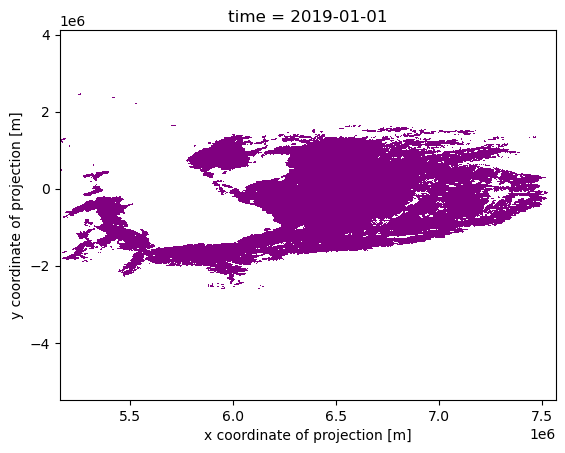

In [11]:
perm_da_sli.PFR.plot.contourf(colors='purple', levels=[0, 1], add_colorbar=False)

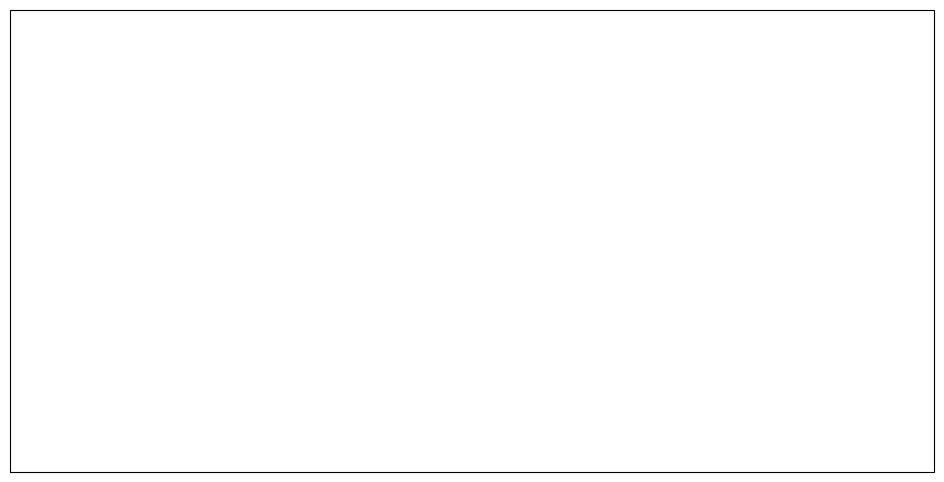

In [12]:
proj = ccrs.PlateCarree()
fig, ax1 = plt.subplots(figsize=(13, 6), subplot_kw={'projection': proj})

x = perm_da_sli.variables['x'][:]
y = perm_da_sli.variables['y'][:]
proj_var = perm_da_sli.variables[perm_da_sli.PFR.grid_mapping]
globe = ccrs.Globe(semimajor_axis=6378137.0)
proj2 = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=0.0,
                          true_scale_latitude=71.0, globe=globe)

#perm_da_sli.PFR.plot(transform=proj2)

In [13]:
# HKH region
hkh_region_path = data_dir + "Shapefiles/hkh/outline.shp"
hkh_region_shape = shapereader.Reader(hkh_region_path)
hkh_region_globe = ccrs.Globe(semimajor_axis=6377276.345, inverse_flattening=300.8017)
hkh_region = ccrs.PlateCarree()

## Hillshade

In [14]:
def hillshade(top_ds, azimuth, angle_altitude):

    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

    z_factor = 0.5
    array = top_ds.elevation.values
    x, y = np.gradient(array)
    x = x / z_factor  # Adjust x gradient
    y = y / z_factor  # Adjust y gradient
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.


    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    
    hillshade = 255*(shaded + 1)/2
   
    return  hillshade

In [15]:
top_ds1['hillshade'] = (('nlat', 'nlon'), hillshade(top_ds1, 315, 80))

In [16]:
np.max(hillshade(top_ds1, 315, 70))
#np.mean(hillshade(top_ds1, 315, 70))

247.3108091502033

## Elevation color map

In [17]:
def keep_center_colormap(vmin, vmax, center=0):
    vmin = vmin - center
    vmax = vmax - center
    dv = max(-vmin, vmax) * 2
    N = int(256 * dv / (vmax-vmin))
    RdBu_r = cm.get_cmap('gist_earth', N)
    newcolors = RdBu_r(np.linspace(0, 1, N))
    beg = int((dv / 2 + vmin)*N / dv)
    end = N - int((dv / 2 - vmax)*N / dv)
    newmap = ListedColormap(newcolors[beg:end])
    return newmap

In [18]:
newmap = keep_center_colormap(-200, 6300, center=0)

## Locations names and dictionaries

In [19]:
other_rivers = ['Naryn', 'Lancang', 'Nu', 'Jinsha', 'Yarkant', 'Hotan', 'Aksu', 'Tuotuo', 'Tongtian', 'Huang','Chang Jiang', 'Dihang', 'Panj', 'Yarlung']

In [21]:
river_dict = {'Indus': [73, 31], 'Ganges': [78, 26], 'Brahmaputra': [94, 26], 
              'Tarim': [81, 39.25], 'Amu Darya': [67, 36.5], 'Mekong': [102, 23], 'Salween': [96.5, 22],
              'Yangtze': [102, 25.5], 'Yellow River': [102.5, 38],}

In [22]:
def regional_rectangle(lonmin, lonmax, latmin, latmax, nvert=100):
    """ Return Polygon object to create regional rectangle on maps."""
    lons = np.r_[
        np.linspace(lonmin, lonmin, nvert),
        np.linspace(lonmin, lonmax, nvert),
        np.linspace(lonmax, lonmax, nvert),
    ].tolist()

    lats = np.r_[
        np.linspace(latmin, latmax, nvert),
        np.linspace(latmax, latmax, nvert),
        np.linspace(latmax, latmin, nvert),
    ].tolist()

    pgon = LinearRing(list(zip(lons, lats)))

    return pgon

In [23]:
region_dict2 = {'HMA1': [71.5, 38], 'HMA2': [76.5, 31], 'HMA3': [93.5, 35],}             

In [24]:
hma1 = regional_rectangle(71, 79, 32, 39)
hma2 = regional_rectangle(76, 93, 27, 32)
hma3 = regional_rectangle(93, 103, 28, 36)

## Plot figure

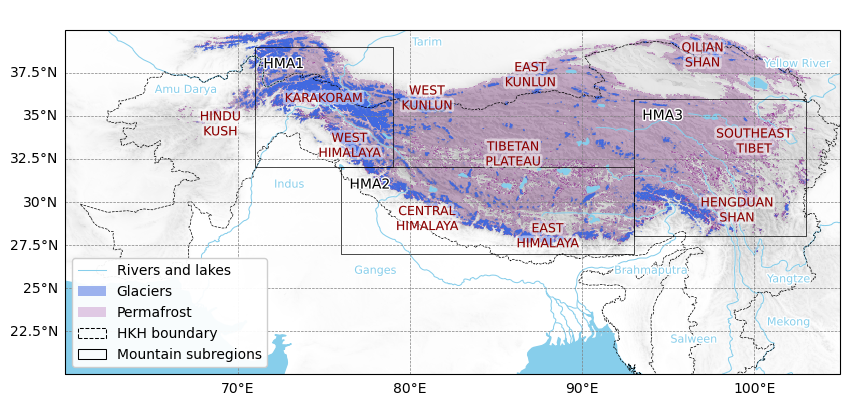

In [58]:
# Figure
proj = ccrs.PlateCarree()
fig, ax1 = plt.subplots(figsize=(10, 6), subplot_kw={'projection': proj})

# Elevation
top_ds1['hs_elev'] = 50*top_ds1.hillshade * top_ds1.elevation**1.3
hs = top_ds1.hs_elev.plot(cmap='gist_yarg', alpha=.5, add_colorbar=False, zorder=-13)
#el = top_ds1.elevation.plot(cmap=newmap, alpha=0.5, vmin=-200, vmax=6300, cbar_kwargs={'label': 'Elevation [m]', 'location':'bottom','pad': 0.07, 'fraction': 0.03, 'aspect': 10, 'extend':'max'})

# Permafrost
#gdf.plot(ax=ax1, color='None', edgecolor='blue', linewidth=0.5, alpha=0.5)
perm_da_sli.PFR.plot.contourf(ax=ax1, colors=['purple'], levels=[0, 1], alpha=0.2, transform=proj2, add_colorbar=False, zorder=-12)

# Glaciers

for glacier in [glaciers13_path, glaciers14_path, glaciers15_path]:
    glaciers_shp = shapereader.Reader(glacier)
    for rec in glaciers_shp.records():
        ax1.add_geometries(rec.geometry, crs=proj, edgecolor='royalblue', facecolor='None', linewidth=0.5, alpha=0.5, zorder=-11)

# Features
ocean_50m = cf.NaturalEarthFeature("physical", "ocean", "50m", edgecolor="face", facecolor='skyblue')
lakes_50m = cf.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="skyblue", facecolor='skyblue')
river_50m = cf.NaturalEarthFeature("physical", "rivers_lake_centerlines", "50m", edgecolor="skyblue", facecolor="None")
ax1.add_feature(ocean_50m, zorder=-10)
ax1.add_feature(lakes_50m, label='lakes', zorder=-9)

# Rivers
for rec in as_shp.records():
    #print(rec.attributes["name"])
    if (rec.attributes["name"] in river_dict.keys())| (rec.attributes["name"] in other_rivers):
        ax1.add_geometries(
                [rec.geometry],
                ccrs.PlateCarree(),
                edgecolor="skyblue",
                facecolor="None",
                linewidth=0.75,
                zorder=-8)

# Mountain boundaries
for rec in hkh_region_shape.records():
    ax1.add_geometries(
        [rec.geometry],
        hkh_region,
        edgecolor="black",
        facecolor="None",
        linestyle='--',
        linewidth=0.5,
        zorder=-7)

# Mountain boundaries
ax1.add_geometries([hma1, hma2, hma3], proj, edgecolor="black",
            facecolor="None", linestyle='-', linewidth=0.5)


# Grid
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
ax1.set_ylabel(" ")
ax1.set_xlabel(" ")
ax1.set_title(" ")
ax1.set_extent([60, 105, 20, 40], crs=proj)

# Text

for region, coord in region_dict.items():
    ax1.text(coord[0], coord[1], region, fontsize=9, color='darkred', ha='center', va='center', zorder=10, 
            path_effects=[pe.withStroke(linewidth=4, foreground="white", alpha=0.5)]) 

for region, coord in region_dict2.items():
    ax1.text(coord[0], coord[1], region, fontsize=10, color='black', ha='left', va='center', zorder=10,
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])

for river, coord in river_dict.items():
    ax1.text(coord[0], coord[1], river, fontsize=8, color='skyblue', ha='center', va='center', zorder=10,
             path_effects=[pe.withStroke(linewidth=2, foreground="white")])

rivers = mlines.Line2D([], [], color='skyblue', marker='None',label='Rivers and lakes', linewidth=0.75)
hkh = Rectangle((0, 0), 1, 1, fc="None", edgecolor='black', linewidth=0.75, label='HKH boundary', linestyle='--')
mountains = Rectangle((0, 0), 1, 1, fc="None", edgecolor='black', linewidth=0.75, label='Mountain subregions')
glaciers = Rectangle((0, 0), 1, 1, fc='royalblue', alpha=0.5, label='Glaciers')
perm = Rectangle((0, 0), 1, 1, fc='purple', alpha=0.2, label='Permafrost')
ax1.legend(handles=[rivers, glaciers, perm, hkh, mountains], loc='lower left', framealpha=0.95)

# rasterize negative zorder
ax1.set_rasterization_zorder(0)
plt.savefig('study_area.pdf', dpi=300, bbox_inches='tight')

In [50]:
region_dict= {'Hindu\n Kush': [69, 34.5], 'Karakoram': [75, 36],
                'West\nKunlun': [81, 36], 'East\nKunlun': [87, 37.35], 'West\nHimalaya': [76.5, 33.25],
                'Qilian\nShan': [97, 38.5], 'Tibetan Plateau': [86, 32.75], 'Southeast\nTibet': [100, 33.5],
                'Hengduan\nShan': [99, 29.5], 'Central\nHimalaya': [81, 29], 'East\nHimalaya': [88, 28],}

In [57]:
# region dict capitalised
region_dict = {'HINDU\nKUSH':[69, 34.5], 'KARAKORAM':[75, 36],
               'WEST\nKUNLUN': [81, 36], 'EAST\nKUNLUN':[87, 37.35], 'WEST\nHIMALAYA': [76.5, 33.25],
                'QILIAN\nSHAN': [97, 38.5], 'TIBETAN\nPLATEAU': [86, 32.75], 'SOUTHEAST\nTIBET': [100, 33.5],
                'HENGDUAN\nSHAN': [99, 29.5], 'CENTRAL\nHIMALAYA': [81, 29], 'EAST\nHIMALAYA': [88, 28],}